<a href="https://colab.research.google.com/github/luigimersico/Topic_modelling/blob/main/Topic_modelling_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

In [ ]:
!pip install pdfplumber nltk gensim matplotlib seaborn PyPDF2 scikit-learn pandas

In [629]:
import os
import PyPDF2
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import gensim
import pdfplumber
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
from gensim import corpora, models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from PyPDF2 import PdfReader
import string
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [630]:
# Set up NLTK resources (download if not available)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [631]:
# Load stop words and create a lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [632]:
# Function to preprocess and clean the text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [token for token in tokens if token.isalnum()]  # Remove non-alphanumeric tokens
    tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    return tokens

In [633]:
# Directory containing PDF files
pdf_directory = "/content/drive/MyDrive/Colab_Notebooks/input_data/reviews on plastic policies"
pdf_directory

'/content/drive/MyDrive/Colab_Notebooks/input_data/reviews on plastic policies'

In [635]:
# Load PDF text from multiple files
#pdf_texts = []
#for filename in os.listdir(pdf_directory):
#    if filename.endswith('.pdf'):
#        with open(os.path.join(pdf_directory, filename), 'rb') as pdf_file:
#            pdf_reader = PdfReader(pdf_file)
#            pdf_text = ' '.join(page.extract_text() for page in pdf_reader.pages)
#            pdf_texts.append(pdf_text)


In [636]:
# Load PDF text from multiple files
pdf_texts = [] #the length of this variable is equal to the number of file stored
pdf_filenames =[] #store the filenames

for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, filename)
        with pdfplumber.open(pdf_path) as pdf:
            pdf_text = ''
            for page in pdf.pages:
                pdf_text += page.extract_text()
            pdf_texts.append(pdf_text)
            pdf_filenames.append(filename)

In [650]:
# Preprocess and clean PDF texts
preprocessed_texts = [preprocess_text(text) for text in pdf_texts]

# Remove documents with zero words/tokens
preprocessed_texts = [text for text in preprocessed_texts if len(text) > 0]

# Rename preprocessed texts
texts = preprocessed_texts

In [ ]:
texts

In [653]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

## Topic modelling with LDA
###1) Find the optimal number of topic
Choosing the optimal number of topics for Latent Dirichlet Allocation (LDA) is a crucial step in topic modeling. Here, the coherence score has been used to determine the appropriate number of topics.

This metric measures the quality of topics by calculating the coherence between the words in the topics. Higher coherence scores indicate better topics.

When using the coherence score to determine the optimal number of topics, you're looking for the number of topics that yields the highest coherence score. This indicates that the topics generated by the model are meaningful, interpretable, and distinct from each other.

Keep in mind that the absolute value of the coherence score doesn't have a universal meaning; its significance lies in the comparison of scores for different numbers of topics. It's also important to note that coherence scores are just one method for evaluating topic models, and other factors, like topic interpretability and domain expertise, should also be considered when selecting the final number of topics.

In [655]:
if len(dictionary) == 0:
    print("Vocabulary is empty. Please review your preprocessing steps.")
else:
  def calculate_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherence_model.get_coherence()
        #coherence_values.append(coherence_model.get_coherence())
        coherence_values.append((num_topics, coherence_value))
    return model_list, coherence_values

In [656]:
# Calculate coherence values
start = 2
limit = 10  # You can adjust this based on your needs
step = 1
model_list, coherence_values = calculate_coherence(dictionary, corpus, texts ,limit, start, step)


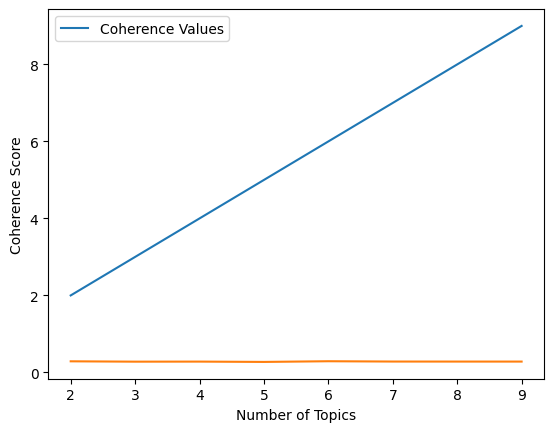

In [657]:
# Plot coherence scores
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(["Coherence Values"], loc='best')
plt.show()

In [658]:
# Function to summarize LDA model results
def summarize_lda_models(model_list, coherence_values, corpus, dictionary, texts):
    results = []
    for num_topics, coherence_score, model in zip(range(start, limit, step), coherence_values, model_list):
        topic_words = model.print_topics()
        topics = []
        for topic in topic_words:
            words = " ".join([word.split("*")[1] for word in topic[1].split(" + ")])
            topics.append(words)
        top_topic = topics[0] if topics else "No topics"
        results.append({
            "Num Topics": num_topics,
            "Coherence Score": coherence_score,
            "Top Topic Words": top_topic
        })

    return results

In [659]:
# Summarize LDA model results
results = summarize_lda_models(model_list, coherence_values, corpus, dictionary, texts)
# Print the summarized results
for result in results:
    print(f"Number of Topics: {result['Num Topics']}")
    print(f"Coherence Score: {result['Coherence Score']}")
    print(f"Top Topic Words: {result['Top Topic Words']}")
    print("=" * 50)


Number of Topics: 2
Coherence Score: (2, 0.28851291827502856)
Top Topic Words: "plastic" "plastics" "policy" "recycling" "et" "policies" "waste" "https" "2020" "ban"
Number of Topics: 3
Coherence Score: (3, 0.2794062937428075)
Top Topic Words: "plastic" "plastics" "policies" "waste" "policy" "et" "https" "recycling" "2020" "2018"
Number of Topics: 4
Coherence Score: (4, 0.2810430100962964)
Top Topic Words: "plastic" "policy" "plastics" "policies" "waste" "et" "recycling" "pollution" "public" "bags"
Number of Topics: 5
Coherence Score: (5, 0.2726663208414906)
Top Topic Words: "plastic" "plastics" "policy" "policies" "waste" "recycling" "et" "2020" "bags" "2018"
Number of Topics: 6
Coherence Score: (6, 0.29051559728007387)
Top Topic Words: "plastic" "policy" "et" "plastics" "recycling" "waste" "https" "policies" "2019" "2020"
Number of Topics: 7
Coherence Score: (7, 0.2824543389490845)
Top Topic Words: "plastic" "plastics" "https" "policy" "waste" "pollution" "et" "policies" "recycling" 

In [660]:
# Find the optimal number of topics with the highest coherence score
optimal_num_topics = max(coherence_values, key=lambda x: x[1])[0]
print(f"Optimal Number of Topics: {optimal_num_topics}")

Optimal Number of Topics: 6


In [661]:
# Train the LDA model with the optimal number of topics (set iterations and passess to avoid problems related to convergence)
iterations_num = 100 # number of iterations
passes_num = 40 # number of passes
lda_model_optimal = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, random_state=42, iterations= iterations_num, passes= passes_num)

In [662]:
# Print topics and their top words
for topic_num, words in lda_model_optimal.print_topics():
    print(f"Topic {topic_num}: {words}")

Topic 0: 0.010*"https" + 0.009*"wiley" + 0.009*"online" + 0.009*"library" + 0.005*"2" + 0.005*"8102" + 0.005*"use" + 0.005*"2023" + 0.004*"see" + 0.004*"applicable"
Topic 1: 0.029*"plastic" + 0.016*"et" + 0.011*"policy" + 0.008*"policies" + 0.007*"waste" + 0.007*"https" + 0.007*"pollution" + 0.006*"ban" + 0.006*"recycling" + 0.006*"2020"
Topic 2: 0.010*"plastic" + 0.007*"2018" + 0.007*"2019" + 0.006*"2017" + 0.005*"2016" + 0.005*"policies" + 0.005*"bans" + 0.005*"pricingmechanism" + 0.004*"plastics" + 0.004*"ban"
Topic 3: 0.058*"plastics" + 0.021*"2022" + 0.016*"waste" + 0.014*"data" + 0.013*"recycling" + 0.012*"packaging" + 0.011*"facts" + 0.011*"2020" + 0.010*"october" + 0.009*"cagr"
Topic 4: 0.014*"plastic" + 0.009*"et" + 0.009*"al" + 0.009*"waste" + 0.008*"plastics" + 0.008*"10" + 0.007*"https" + 0.007*"2020" + 0.006*"treatment" + 0.006*"water"
Topic 5: 0.025*"plastic" + 0.017*"policy" + 0.011*"policies" + 0.011*"plastics" + 0.009*"waste" + 0.007*"evidence" + 0.007*"recycling" + 0.

In [663]:
# Analyze topics and documents using the optimal LDA model
document_topic_distribution = [lda_model_optimal[doc] for doc in corpus]

# Identify the most dominant topic for each document
dominant_topics = [max(doc, key=lambda item: item[1])[0] for doc in document_topic_distribution]

# Create a dictionary to store document IDs under each topic
topics_per_document = {topic: [] for topic in range(optimal_num_topics)}
for doc_id, topic in enumerate(dominant_topics):
  topics_per_document[topic].append(doc_id)

# Print summaries of topics and associated documents
for topic, documents in topics_per_document.items():
    print(f"Topic {topic}:")
    print("Documents:", documents)
    print("Number of Documents:", len(documents))
    print("-" * 20)

Topic 0:
Documents: [2]
Number of Documents: 1
--------------------
Topic 1:
Documents: [1, 4, 7]
Number of Documents: 3
--------------------
Topic 2:
Documents: [5]
Number of Documents: 1
--------------------
Topic 3:
Documents: [9]
Number of Documents: 1
--------------------
Topic 4:
Documents: [8]
Number of Documents: 1
--------------------
Topic 5:
Documents: [0, 3, 6]
Number of Documents: 3
--------------------


In [664]:
# Calculate and print the distribution of dominant topics
from collections import Counter
topic_counts = Counter(dominant_topics)
total_documents = len(dominant_topics)
print("Dominant Topic Distribution:")
for topic, count in topic_counts.items():
    percentage = (count / total_documents) * 100
    print(f"Topic {topic}: {percentage:.2f}%")

Dominant Topic Distribution:
Topic 5: 30.00%
Topic 1: 30.00%
Topic 0: 10.00%
Topic 2: 10.00%
Topic 4: 10.00%
Topic 3: 10.00%


In [665]:
# Create a DataFrame to store the information
data = []
for topic, count in topic_counts.items():
    percentage = (count / total_documents) * 100
    data.append([topic, count, f"{percentage:.2f}%"])

In [666]:
# Create the DataFrame
df = pd.DataFrame(data, columns=["Topic", "Number of Documents", "Distribution (%)"])

# Print the DataFrame
print(df)

   Topic  Number of Documents Distribution (%)
0      5                    3           30.00%
1      1                    3           30.00%
2      0                    1           10.00%
3      2                    1           10.00%
4      4                    1           10.00%
5      3                    1           10.00%


In [668]:
# Having a list of documents, dominant topics, and their distributions
# 1) Count the number of documents associated with each topic
topic_counts = Counter(dominant_topics)

# 2) Calculate the total number of documents
total_documents = len(pdf_filenames)

# 3) Create a list to store the table data
table_data = []

In [669]:
data = {
    'Document Title': pdf_filenames,
    'Dominant Topic': dominant_topics,
    'Topic Distribution': percentage
}

In [670]:
data

{'Document Title': ['GPPC-Report.pdf',
  'a review on plastic value chain.pdf',
  'J of Industrial Ecology - 2023 - Olatayo.pdf',
  '1-s2.0-S0308597X19304865-main.pdf',
  '1-s2.0-S0956053X19300960-main.pdf',
  'Government policies combatting plastic pollution.pdf',
  'WIREs Energy   Environment - 2019 - Nielsen.pdf',
  'The evolving global plastics policy landscape_ An inventory and effectiveness review.pdf',
  's11356-021-18038-5.pdf',
  'PE-PLASTICS-THE-FACTS_FINAL_DIGITAL-1.pdf'],
 'Dominant Topic': [5, 1, 0, 5, 1, 2, 5, 1, 4, 3],
 'Topic Distribution': 10.0}

In [672]:
df = pd.DataFrame(data)
df.to_csv('topic_distributions.csv', index=False)